## 11. Espectro de los parámetros

Hemos podido comprobar que el espectro de la energía no era el culpable de la facilidad de distinción de los datos reales y los simulados. Ahora solo me quedan dos teorías posibles:
1. Que el responsable sea el espectro de los parámetros, es decir, que como los parámetros reales se exceden y sobrepasan el espectro de los parámetros simulados eso le de la pista al RF de que sea un simulado o un real
2. Que el responsable sea la relación entre los parámetros, es decir, que la relación entre uno y otro sea quien le chive al RF si es simulado o real.

### 1. Espectro de los parámetros

Vamos a filtrar nuestros datos para que el dataframe con que se entrena y testea tenga únicamente los valores de los datos simulados y así, acotando los datos reales quizás obtengamos mejores resultados.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ctapipe.io import TableLoader, read_table
import scipy

# RandomForest
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.datasets import make_regression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Distribución del clasificador
import scipy.stats as stats

/tmp/ipykernel_2024/1269661234.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [4]:
# Cargamos imágenes SIMULADAS
with TableLoader("../datos/proton.dl2.h5", load_dl1_images=True, load_dl2=True,load_simulated=True) as loader_p:
    protons_tel_events = loader_p.read_telescope_events("LST_LST_LSTCam", start=0, stop=1647471)
with TableLoader("../datos/gamma-diffuse.dl2.h5", load_dl1_images=True,load_dl2=True, load_simulated=True) as loader_g:
    gamma_tel_events = loader_g.read_telescope_events("LST_LST_LSTCam", start=0, stop=1452118)

with TableLoader("../datos/proton_with_images_00.dl2.h5", load_dl1_images=True, load_dl2=True,load_simulated=True) as loader_p:
    protons_tel_events2 = loader_p.read_telescope_events("LST_LST_LSTCam", start=0, stop=82178)
with TableLoader("../datos/gamma-diffuse_with_images_00.dl2.h5", load_dl1_images=True,load_dl2=True, load_simulated=True) as loader_g:
    gamma_tel_events2 = loader_g.read_telescope_events("LST_LST_LSTCam", start=0, stop=33922
)

# Determinamos los parámetros
features = [
 #'obs_id',
 #'event_id',                          
 #'tel_id',
 'hillas_intensity',
 'hillas_skewness',
 'hillas_kurtosis',
 #'hillas_r',
 #'hillas_phi',
 'hillas_length',
 'hillas_width',
 #'hillas_psi',
 #'timing_intercept',
 #'timing_deviation',
 'timing_slope',
 #'leakage_intensity_width_2',
 #'true_energy'
]

protons_tel_events_f = protons_tel_events[features] 
gamma_tel_events_f=gamma_tel_events[features]
protons_tel_events_f2 = protons_tel_events2[features] 
gamma_tel_events_f2=gamma_tel_events2[features]

# Convertimos a dataframe
df_protons = protons_tel_events_f.to_pandas()
df_protons = df_protons.dropna()

df_protons2 = protons_tel_events_f2.to_pandas()
df_protons2 = df_protons2.dropna()

df_gamma = gamma_tel_events_f.to_pandas()
df_gamma = df_gamma.dropna()

df_gamma2 = gamma_tel_events_f2.to_pandas()
df_gamma2 = df_gamma2.dropna()

# Juntamos los cuatro dataframe
df_protongamma = pd.concat([df_protons, df_protons2, df_gamma, df_gamma2], axis=0)

# Cargamos las imágenes REALES
tablename = "/dl2/event/telescope/parameters/LST_LSTCam"
file = "../datos/dl2_LST-1.Run02949.h5"
tb = pd.read_hdf(file, tablename)

# Las columnas deben estar en el mismo orden que en el fit (las de MC)
features = [
            #'obs_id',
            #'event_id',
            'intensity',
            'skewness',
            'kurtosis',
            #'log_intensity',
            #'x',
            #'y',
            #'r',
            #'phi',
            'length',
            #'length_uncertainty',
            'width',
            #'width_uncertainty',
            #'psi',
            'time_gradient',
            #'intercept',
            #'leakage_intensity_width_1',
            #'leakage_intensity_width_2',
            #'leakage_pixels_width_1',
            #'leakage_pixels_width_2',
            #'n_pixels',
            #'concentration_cog',
            #'concentration_core',
            #'concentration_pixel',
            #'n_islands',
            #'alt_tel',
            #'az_tel',
            #'calibration_id',
            #'dragon_time',
            #'ucts_time',
            #'tib_time',
            #'ucts_jump',
            #'mc_type',
            #'wl',
            #'tel_id',
            #'tel_pos_x',
            #'tel_pos_y',
            #'tel_pos_z',
            #'trigger_type',
            #'ucts_trigger_type',
            #'trigger_time',
            'event_type',
            #'delta_t',
            #'log_reco_energy',
            #'reco_energy',
            #'reco_disp_norm',
            #'reco_disp_sign',
            #'reco_disp_dx',
            #'reco_disp_dy',
            #'reco_src_x',
            #'reco_src_y',
            #'signed_time_gradient',
            #'signed_skewness',
            #'reco_alt',
            #'reco_az',
            #'reco_type',
            #'gammaness'
            ]

df_realC = tb[features]
df_realC = df_realC.dropna()
# Debemos cambiar el nombre de las features para que sean el mismo que el de MC ya que sino el RF no sabrá cuál es cuál
df_realC.rename(columns={'intensity': 'hillas_intensity', 'length': 'hillas_length', 'width': 'hillas_width', 'skewness': 'hillas_skewness',
                        'kurtosis': 'hillas_kurtosis', 'time_gradient': 'timing_slope'}, inplace=True)

# Filtramos nuestro dataframe para únicamente los eventos de tipo 32 y 2 (nos quita los eventos de tipo 1)
df_realC = df_realC[(df_realC['event_type'] >= 2)]
df_realC = df_realC.drop("event_type", axis=1)

# Dataframe de datos simulados
df_simu = df_protongamma
df_real = df_realC

# Creamos la etiqueta para que el modelo pueda comprobar sus resultados
label = []                                                                                             
for i in range(len(df_simu)):
    label.append(1)                                                                   # Nombramos los simulados como 1
for j in range(len(df_real)):
    label.append(0)                                                                   # Nombramos los reales como 0

# Los concatenamos para juntar todos los datos en el mismo dataframe
df_simureal = pd.concat([df_simu, df_real], axis=0)

df_simureal.insert(6,"label", label, True)

In [5]:
# Filtramos los parámetros para que solo nos quedemos con los valores que se parecen entre simulados y reales
# Intensidad: 5*10^1 - 10^5
# Skewness: -4 - 4
# Kurtosis: 1 - 10
# Length: 5*10^(-2) - 1.5
# Width: 0 - 0.6
# Time gradient: -50 - 50

# Dataframe filtrado
df_simureal_filtrado = df_simureal[
    (df_simureal['hillas_intensity'] >= 50) & (df_simureal['hillas_intensity'] <= 10**5) &
    (df_simureal['hillas_skewness'] >= -4) & (df_simureal['hillas_skewness'] <= 4) &
    (df_simureal['hillas_kurtosis'] >= 1) & (df_simureal['hillas_kurtosis'] <= 10) &
    (df_simureal['hillas_length'] >= 0.05) & (df_simureal['hillas_length'] <= 1.5) &
    (df_simureal['hillas_width'] >= 0) & (df_simureal['hillas_width'] <= 0.6) &
    (df_simureal['timing_slope'] >= -50) & (df_simureal['timing_slope'] <= 50)
]

df_simureal_filtrado

,hillas_intensity,hillas_skewness,hillas_kurtosis,hillas_length,hillas_width,timing_slope,label
3,577.332421,0.188235,1.695745,0.308969,0.167774,-4.760660,1
5,552.692280,-0.348821,2.403907,0.184209,0.071960,1.045219,1
6,85.066560,0.026679,2.577278,0.070429,0.052465,-2.486243,1
7,199.742964,-0.069528,2.337806,0.072453,0.059627,-0.262027,1
10,108.504216,0.058063,1.849918,0.108638,0.056007,-7.665957,1
...,...,...,...,...,...,...,...
4909661,149.821190,0.576223,2.103140,0.122233,0.056672,-2.439203,0
4909663,842.649723,0.141102,2.204103,0.397834,0.099812,-0.907546,0
4909664,98.708838,0.261321,2.564612,0.096024,0.056713,0.656314,0
4909665,106.448409,0.389992,2.332329,0.112202,0.028539,-5.205076,0


In [8]:
X = df_simureal_filtrado.drop("label", axis=1)                                              # Determina los parámetros 
y = df_simureal_filtrado["label"]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
rfrs = RandomForestClassifier(max_depth=19, n_estimators=150)
rfrs.fit(X_train, y_train)

RandomForestClassifier(max_depth=19, n_estimators=150)

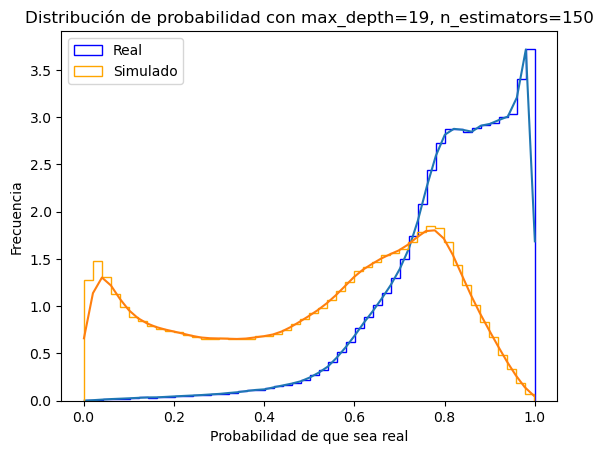

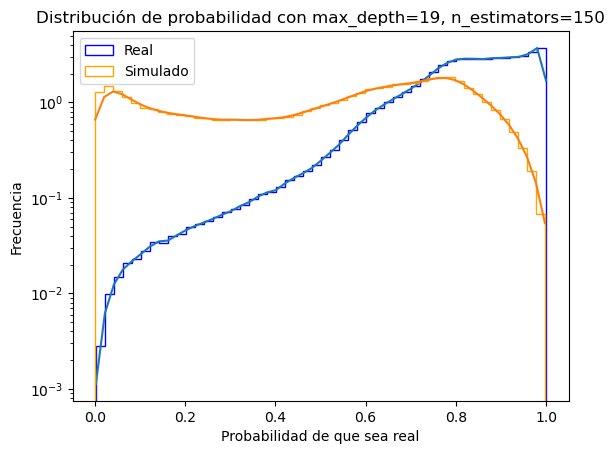

In [10]:
y_pred = (rfrs.predict_proba(X_test))
proba = y_pred[:,0]                                                                             # Probabilidad de que el suceso sea un gamma
label = y_test                                                                                   # Etiqueta real del suceso
    
# Asignamos a cada probabilidad que devuelve el RF la etiqueta real del suceso
prob_real = proba[label == 0]
prob_simu = proba[label == 1]

densityr = stats.gaussian_kde(prob_real)
nr, xr, _ = plt.hist(prob_real, bins=50, density=True, histtype=u'step', color = 'blue', label='Real')  
plt.plot(xr, densityr(xr))

densitys = stats.gaussian_kde(prob_simu)
ns, xs, _ = plt.hist(prob_simu, bins=50, density=True, histtype=u'step', color = 'orange', label='Simulado')  
plt.plot(xs, densitys(xs))

plt.title("Distribución de probabilidad con max_depth=19, n_estimators=150")
plt.xlabel("Probabilidad de que sea real")
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

# Representamos el espectro en escala logarítmica
densityr = stats.gaussian_kde(prob_real)
nr, xr, _ = plt.hist(prob_real, bins=50, density=True, histtype=u'step', color = 'blue', label='Real')  
plt.plot(xr, densityr(xr))

densitys = stats.gaussian_kde(prob_simu)
ns, xs, _ = plt.hist(prob_simu, bins=50, density=True, histtype=u'step', color = 'orange', label='Simulado')  
plt.plot(xs, densitys(xs))

plt.title("Distribución de probabilidad con max_depth=19, n_estimators=150")
plt.xlabel("Probabilidad de que sea real")
plt.ylabel('Frecuencia')
plt.yscale('log')
plt.legend()
plt.show()

El espectro de simulados es igual que en casos anteriores y el de reales contiene menos datos. Aún así, los sigue distinguiendo muy bien por lo que el hecho de que los datos reales tengan valores diferentes no es el culpable de esta separación.

### 2. Relación entre los parámetros

Solo nos queda un último sospechoso: la relación entre parámetros de reales y simulados. Esto se descartó pues en el notebook 10 vimos cómo la distribución era bastante similar, sin embargo, debe haber algo que se nos está escapando. Cómo voy a trabajar:
1. Distinguir los datos con realness > 0.75 y los realness < 0.25 y clasificarlos en reales o simulados
2. Una vez tenga estos datos vamos a realizar una comparación de todos ellos entre sí y descifrar la diferencia entre ellos
3. Si esto no es posible, dividiremos uno plot entre el otro para poder resaltar mejor las diferencias (habrá que normalizar los plots y otros ajustes varios).

Como la distinción anterior no es buena, vamos a cargar los resultados del RF más general:

In [11]:
# Cargamos los datos generados anteriormente para no tener que volver a entrenar el RandomForest:
X_test_total = np.loadtxt("X_test_total")
X_train_total = np.loadtxt("X_train_total")
y_test_total = np.loadtxt("y_test_total")
y_train_total = np.loadtxt("y_train_total")
y_pred_total = np.loadtxt("y_pred_total")

In [12]:
realness = y_pred_total[:,0]

In [13]:
# Juntamos todos los datos
X = np.column_stack((X_test_total, y_test_total))
X = np.column_stack((X, realness))

In [14]:
# Separamos los datos en reales y simulados
X_reales = X[X[:, 6] == 0]
X_simulados = X[X[:, 6] == 1]

# Separamos los reales y simulados en más reales y más simulados
X_simulados_mas = X_simulados[X_simulados[:,7] <= 0.25]
X_simulados_menos = X_simulados[X_simulados[:,7] >= 0.75]
X_reales_mas = X_reales[X_reales[:,7] >= 0.75]
X_reales_menos = X_reales[X_reales[:,7] <= 0.25]

In [7]:
# Preparamos la representación
import mpl_scatter_density # adds projection='scatter_density'
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches

# "Viridis-like" colormap with white background
white_viridis = LinearSegmentedColormap.from_list('white_viridis', [
    (0, '#ffffff'),
    (1e-20, '#440053'),
    (0.2, '#404388'),
    (0.4, '#2a788e'),
    (0.6, '#21a784'),
    (0.8, '#78d151'),
    (1, '#fde624'),
], N=256)

def using_mpl_scatter_density(ax, x, y):
    if np.all(x > 0):
        ax.set_xscale('log')
    if np.all(y > 0):
        ax.set_yscale('log')
    density = ax.scatter_density(x, y, cmap=white_viridis)

titles = ['Intensity', 'Skweness', 'Kurtosis', 'Length', 'Width', 'Time slope']

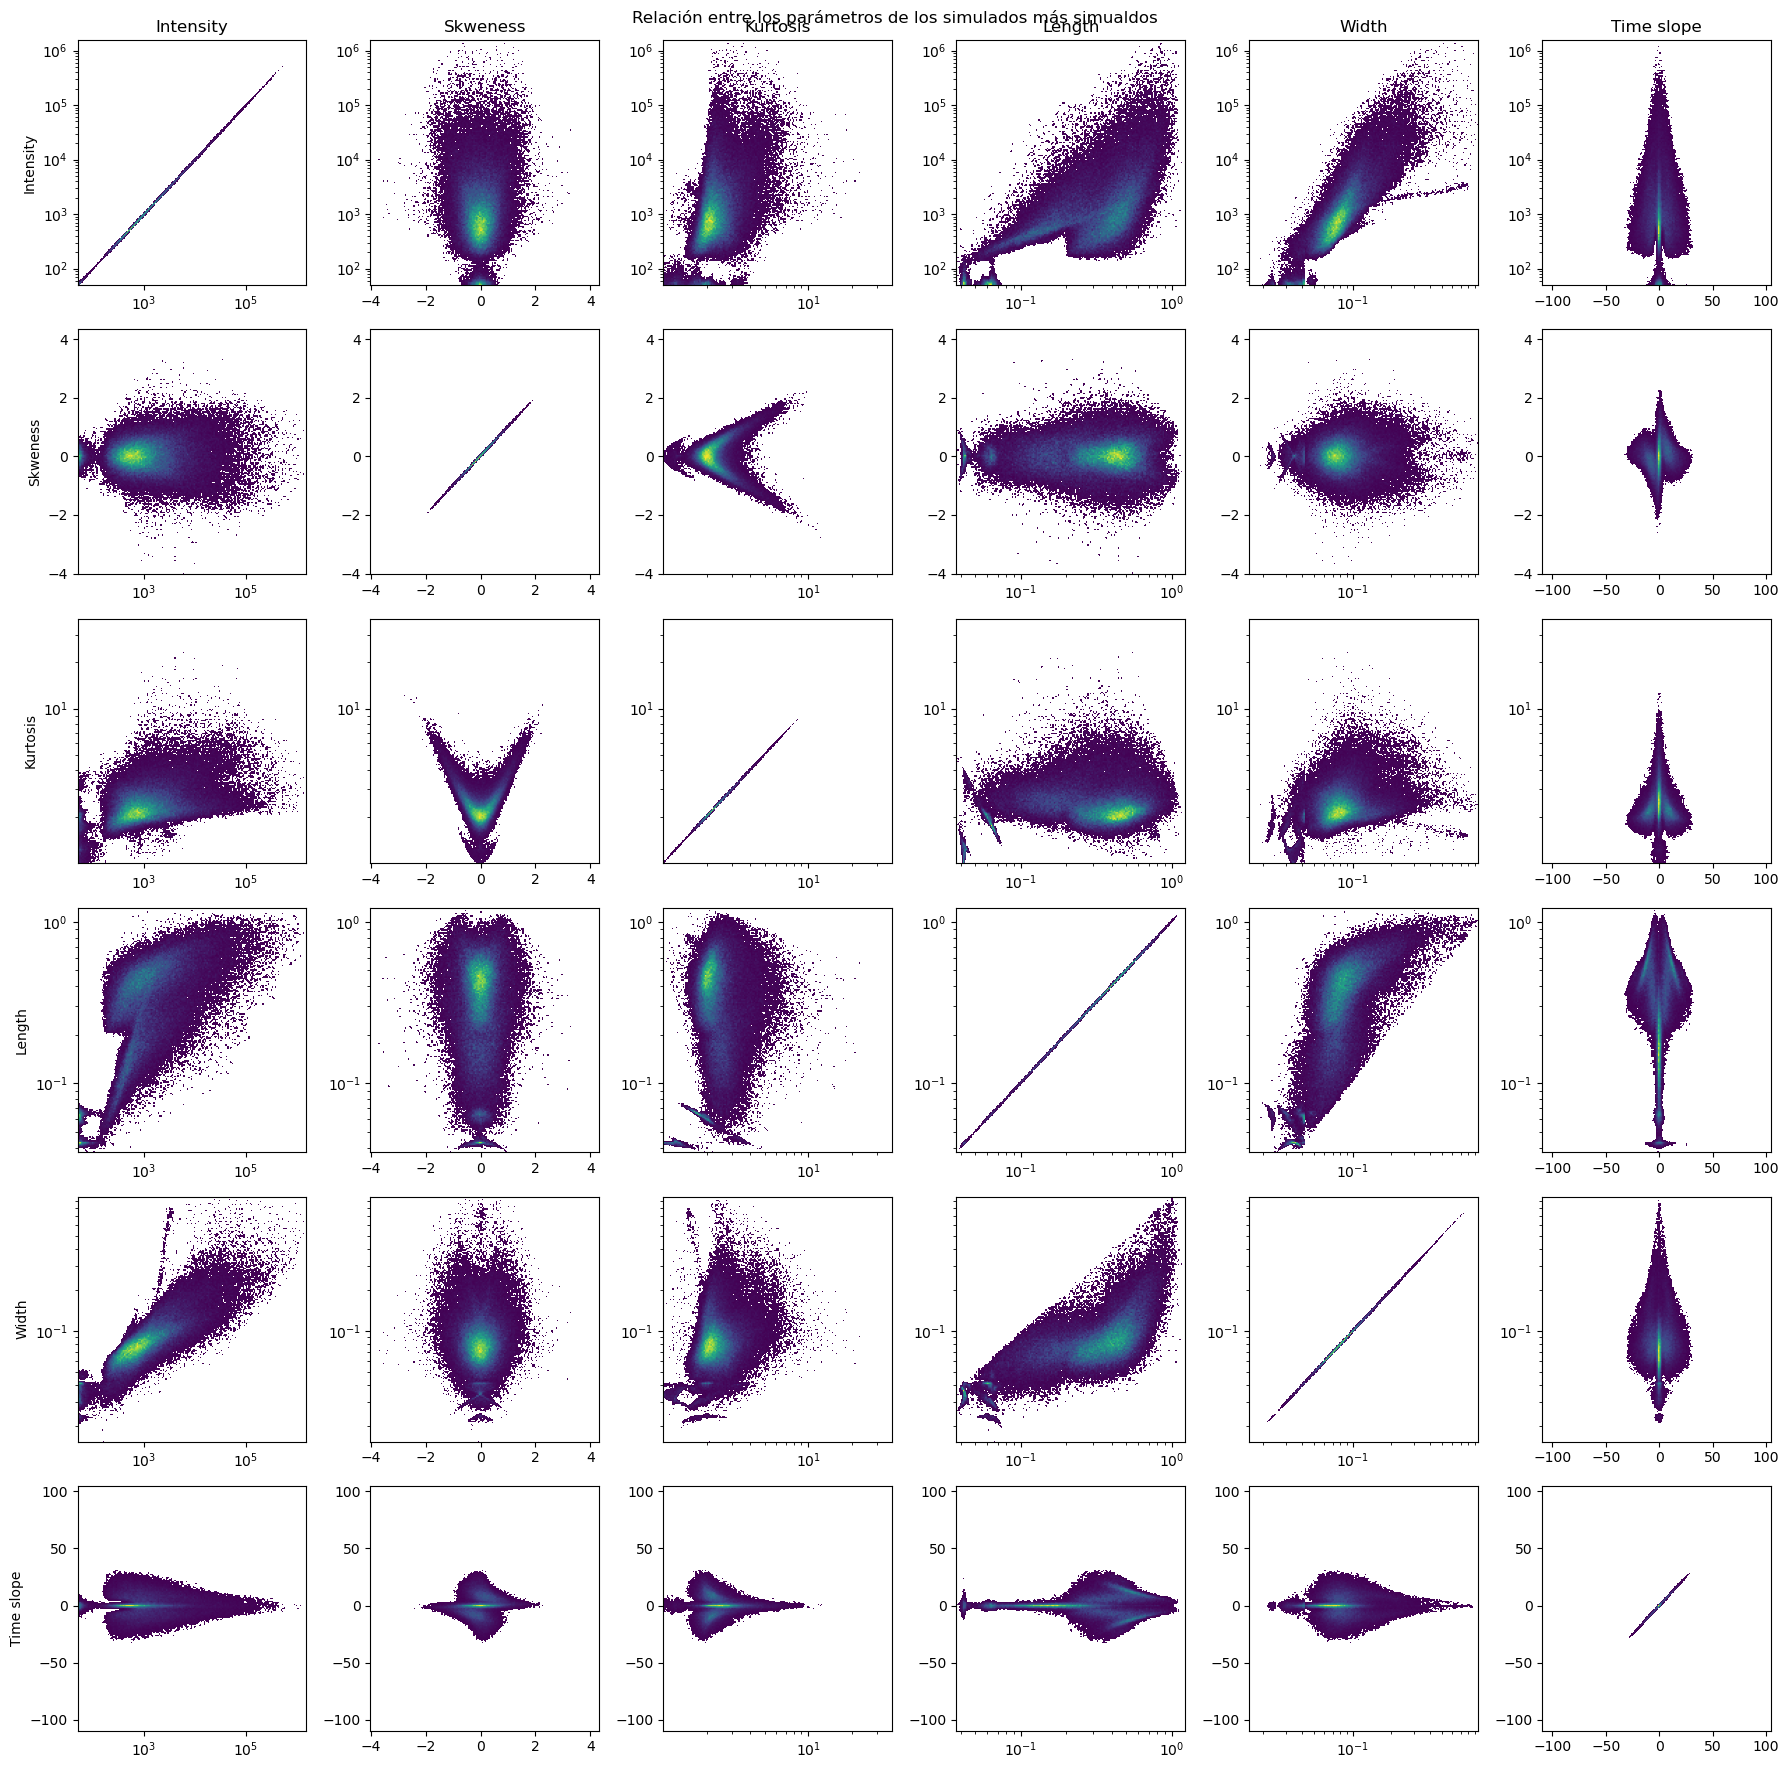

In [20]:
# Crear una cuadrícula de subplots 6x6
fig = plt.figure(figsize=(18, 18))

# Iterar sobre cada subplot y llamar a la función con los datos correspondientes
for i in range(6):
    for j in range(6):
        ax = fig.add_subplot(6, 6, i * 6 + j + 1, projection='scatter_density')
        
        # Establecer títulos de los ejes x e y
        xlabel = titles[j]
        ylabel = titles[i]
        
        # Añadir títulos solo a los subplots del borde
        if i == 0:
            ax.set_title(f"{xlabel}")
        if j == 0:
            ax.set_ylabel(f"{ylabel}")

        # Representar los datos
        using_mpl_scatter_density(ax, X_simulados_mas[:, j], X_simulados_mas[:, i])

plt.suptitle('Relación entre los parámetros de los simulados más simualdos')
plt.tight_layout()
plt.show()

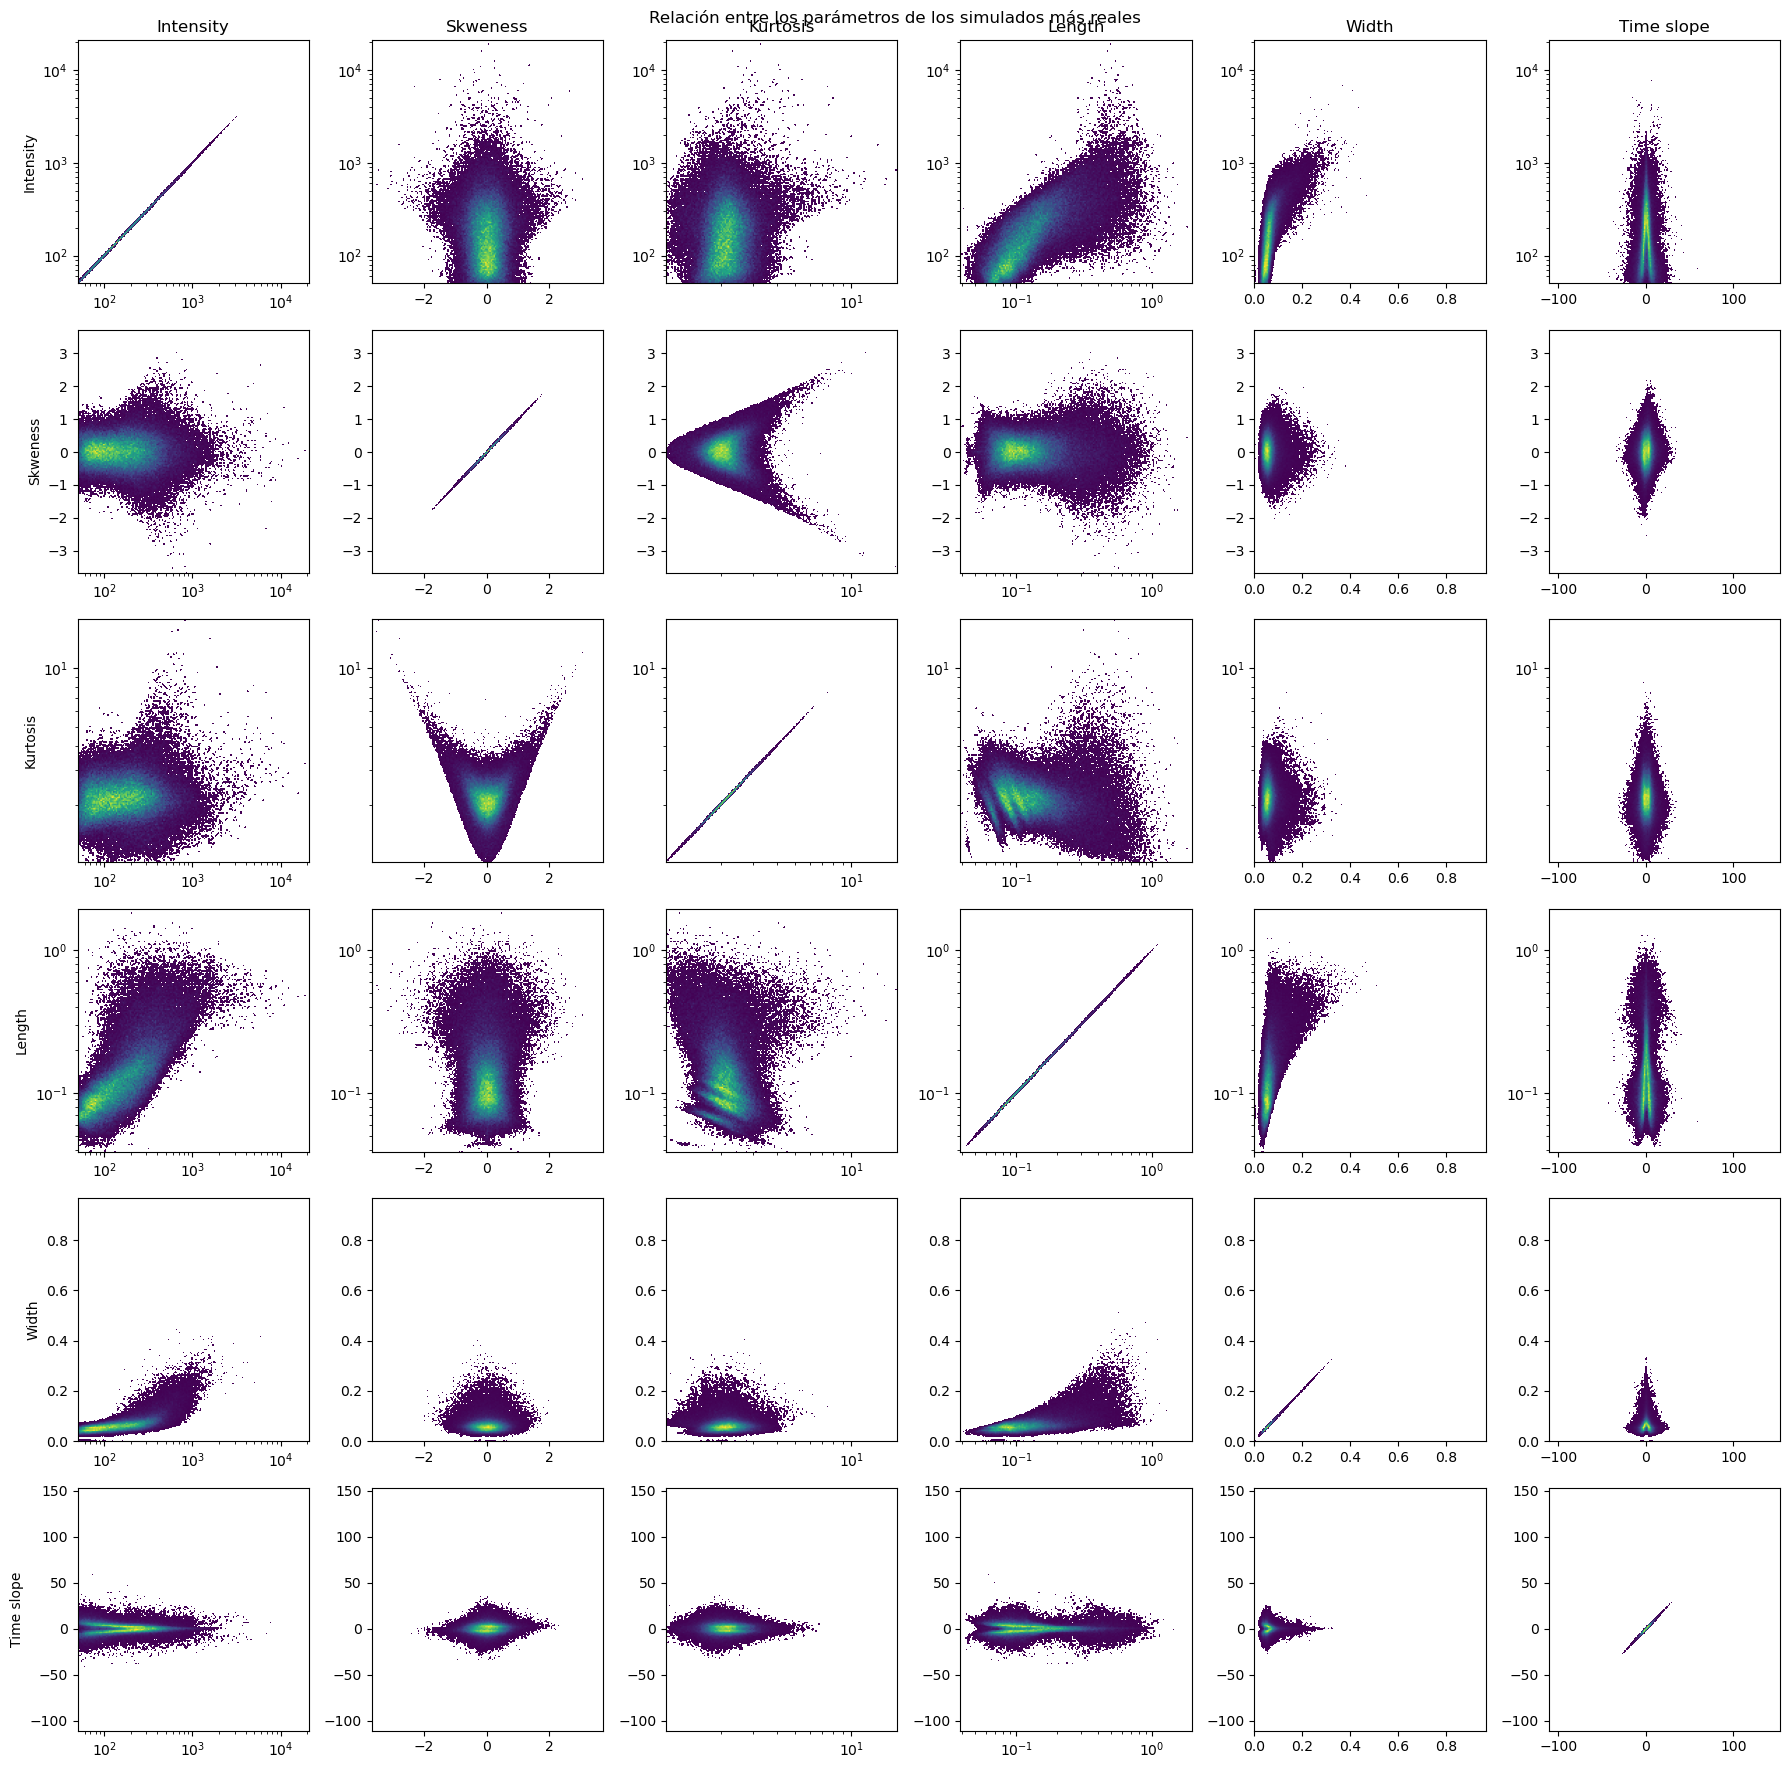

In [16]:
# Crear una cuadrícula de subplots 6x6
fig = plt.figure(figsize=(18, 18))

# Iterar sobre cada subplot y llamar a la función con los datos correspondientes
for i in range(6):
    for j in range(6):
        ax = fig.add_subplot(6, 6, i * 6 + j + 1, projection='scatter_density')
        
        # Establecer títulos de los ejes x e y
        xlabel = titles[j]
        ylabel = titles[i]
        
        # Añadir títulos solo a los subplots del borde
        if i == 0:
            ax.set_title(f"{xlabel}")
        if j == 0:
            ax.set_ylabel(f"{ylabel}")

        # Representar los datos
        using_mpl_scatter_density(ax, X_simulados_menos[:, j], X_simulados_menos[:, i])

plt.suptitle('Relación entre los parámetros de los simulados más reales')
plt.tight_layout()
plt.show()

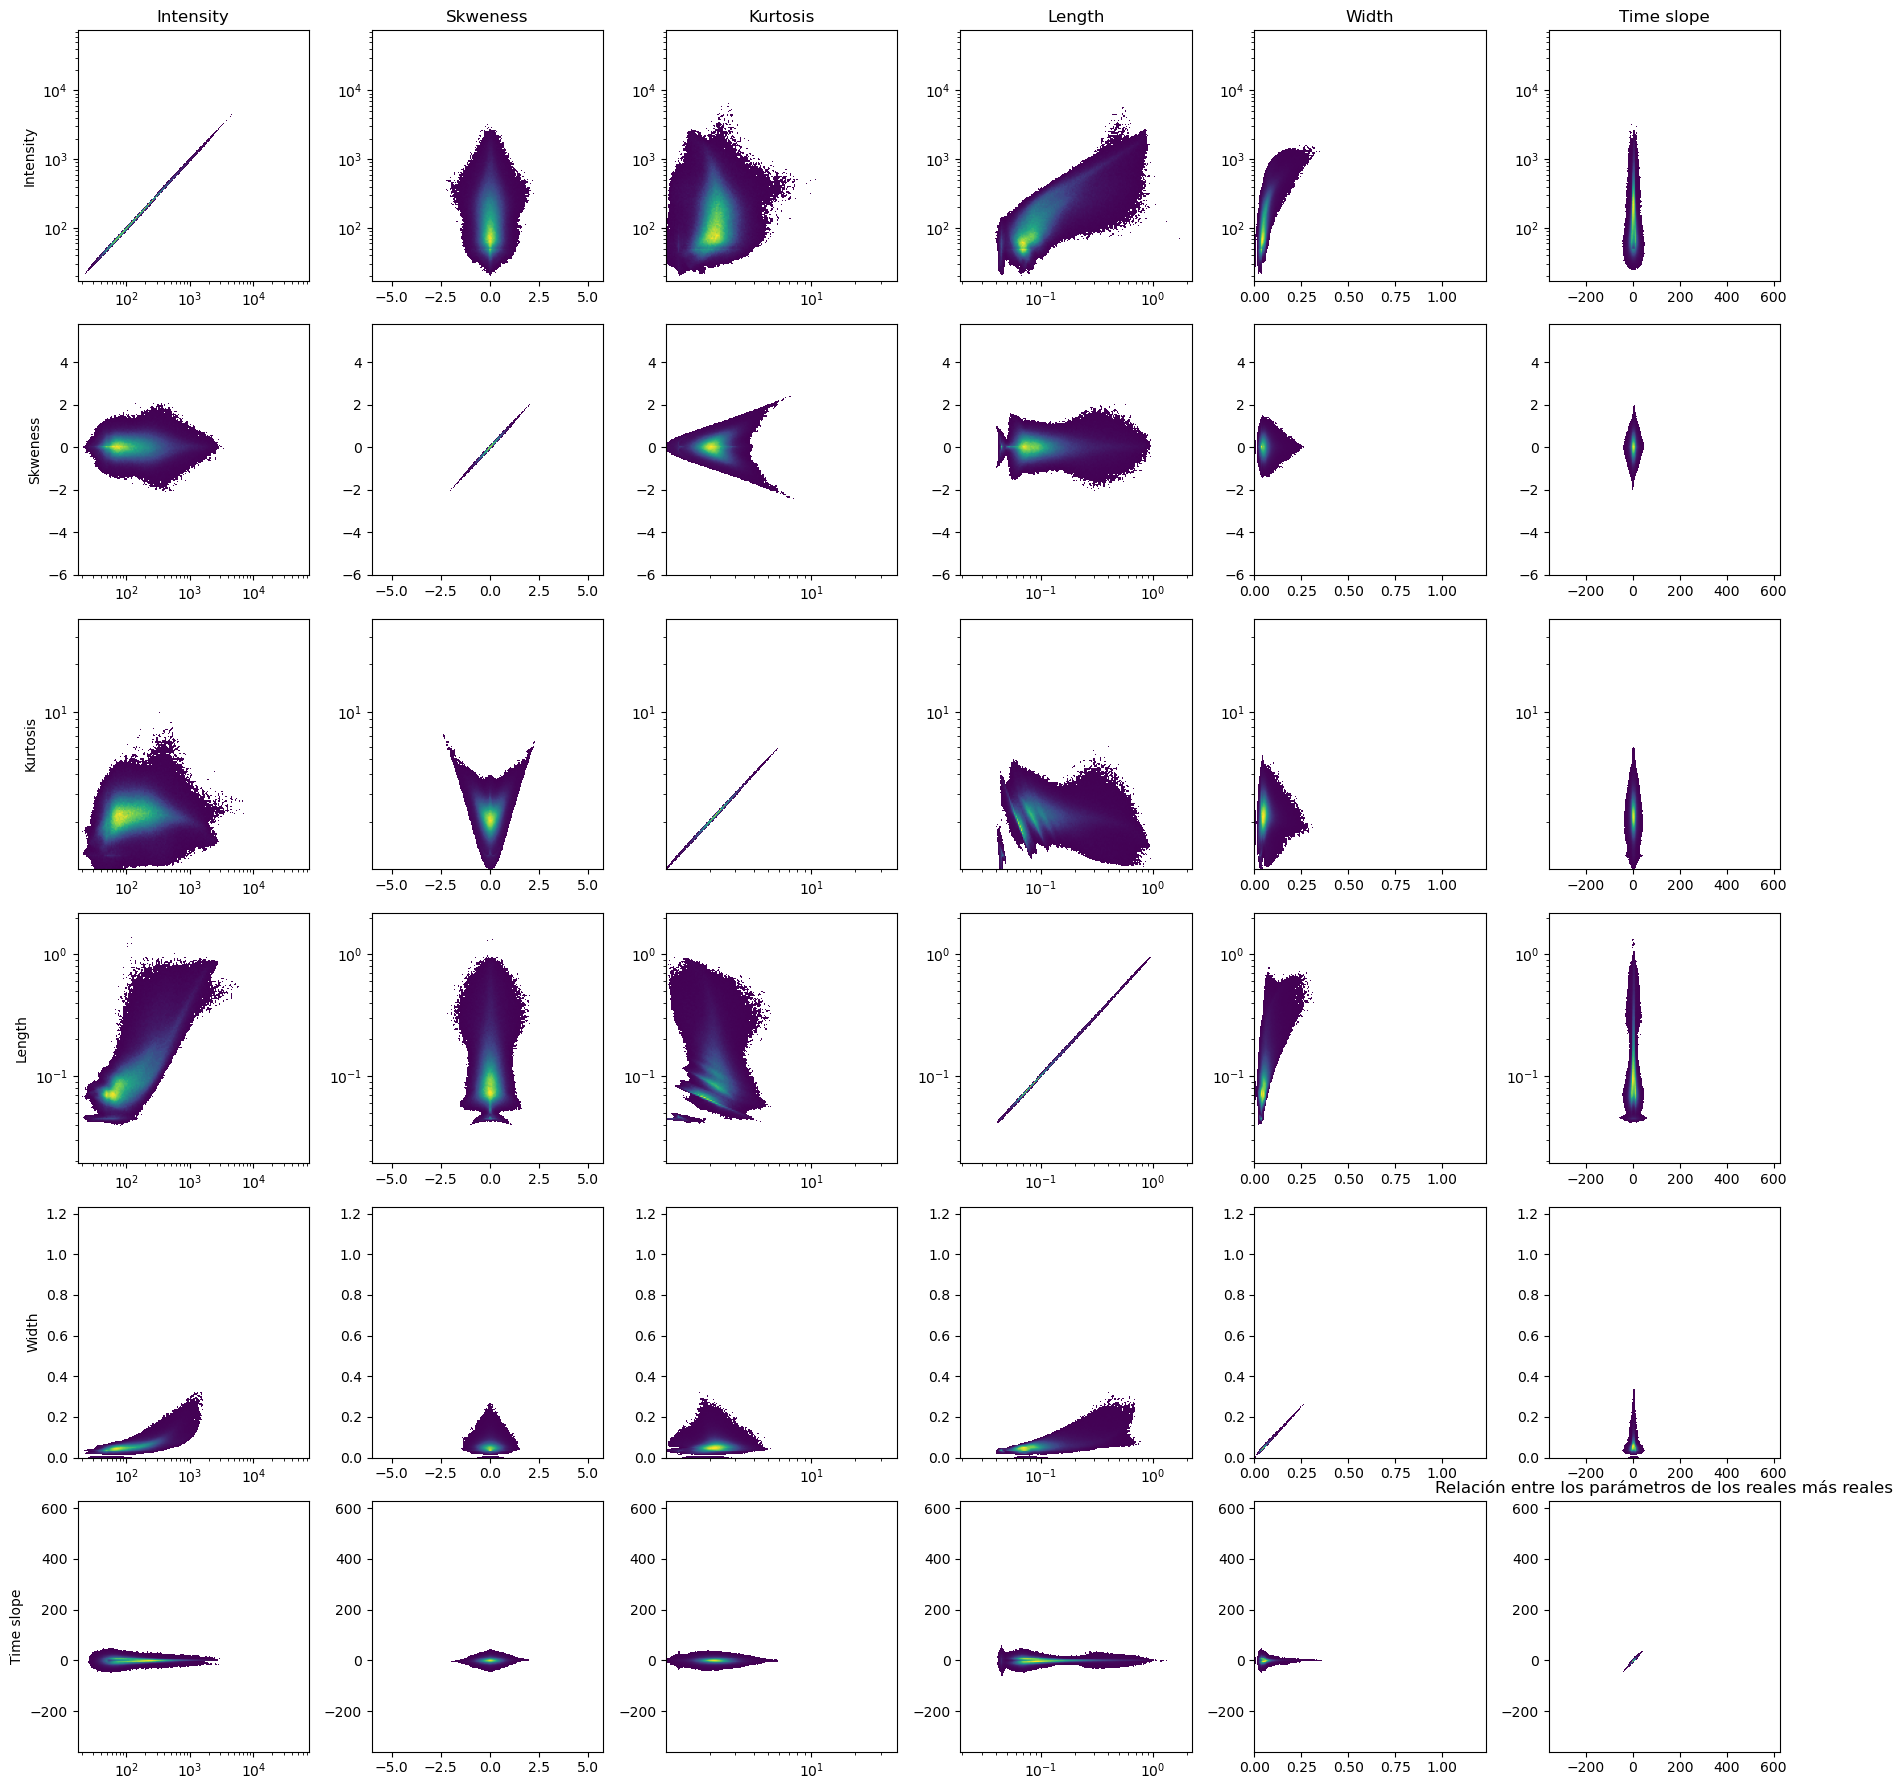

In [10]:
# Crear una cuadrícula de subplots 6x6
fig = plt.figure(figsize=(18, 18))

# Iterar sobre cada subplot y llamar a la función con los datos correspondientes
for i in range(6):
    for j in range(6):
        ax = fig.add_subplot(6, 6, i * 6 + j + 1, projection='scatter_density')
        
        # Establecer títulos de los ejes x e y
        xlabel = titles[j]
        ylabel = titles[i]
        
        # Añadir títulos solo a los subplots del borde
        if i == 0:
            ax.set_title(f"{xlabel}")
        if j == 0:
            ax.set_ylabel(f"{ylabel}")

        # Representar los datos
        using_mpl_scatter_density(ax, X_reales_mas[:, j], X_reales_mas[:, i])
        
plt.tight_layout()
plt.title('Relación entre los parámetros de los reales más reales')
plt.show()

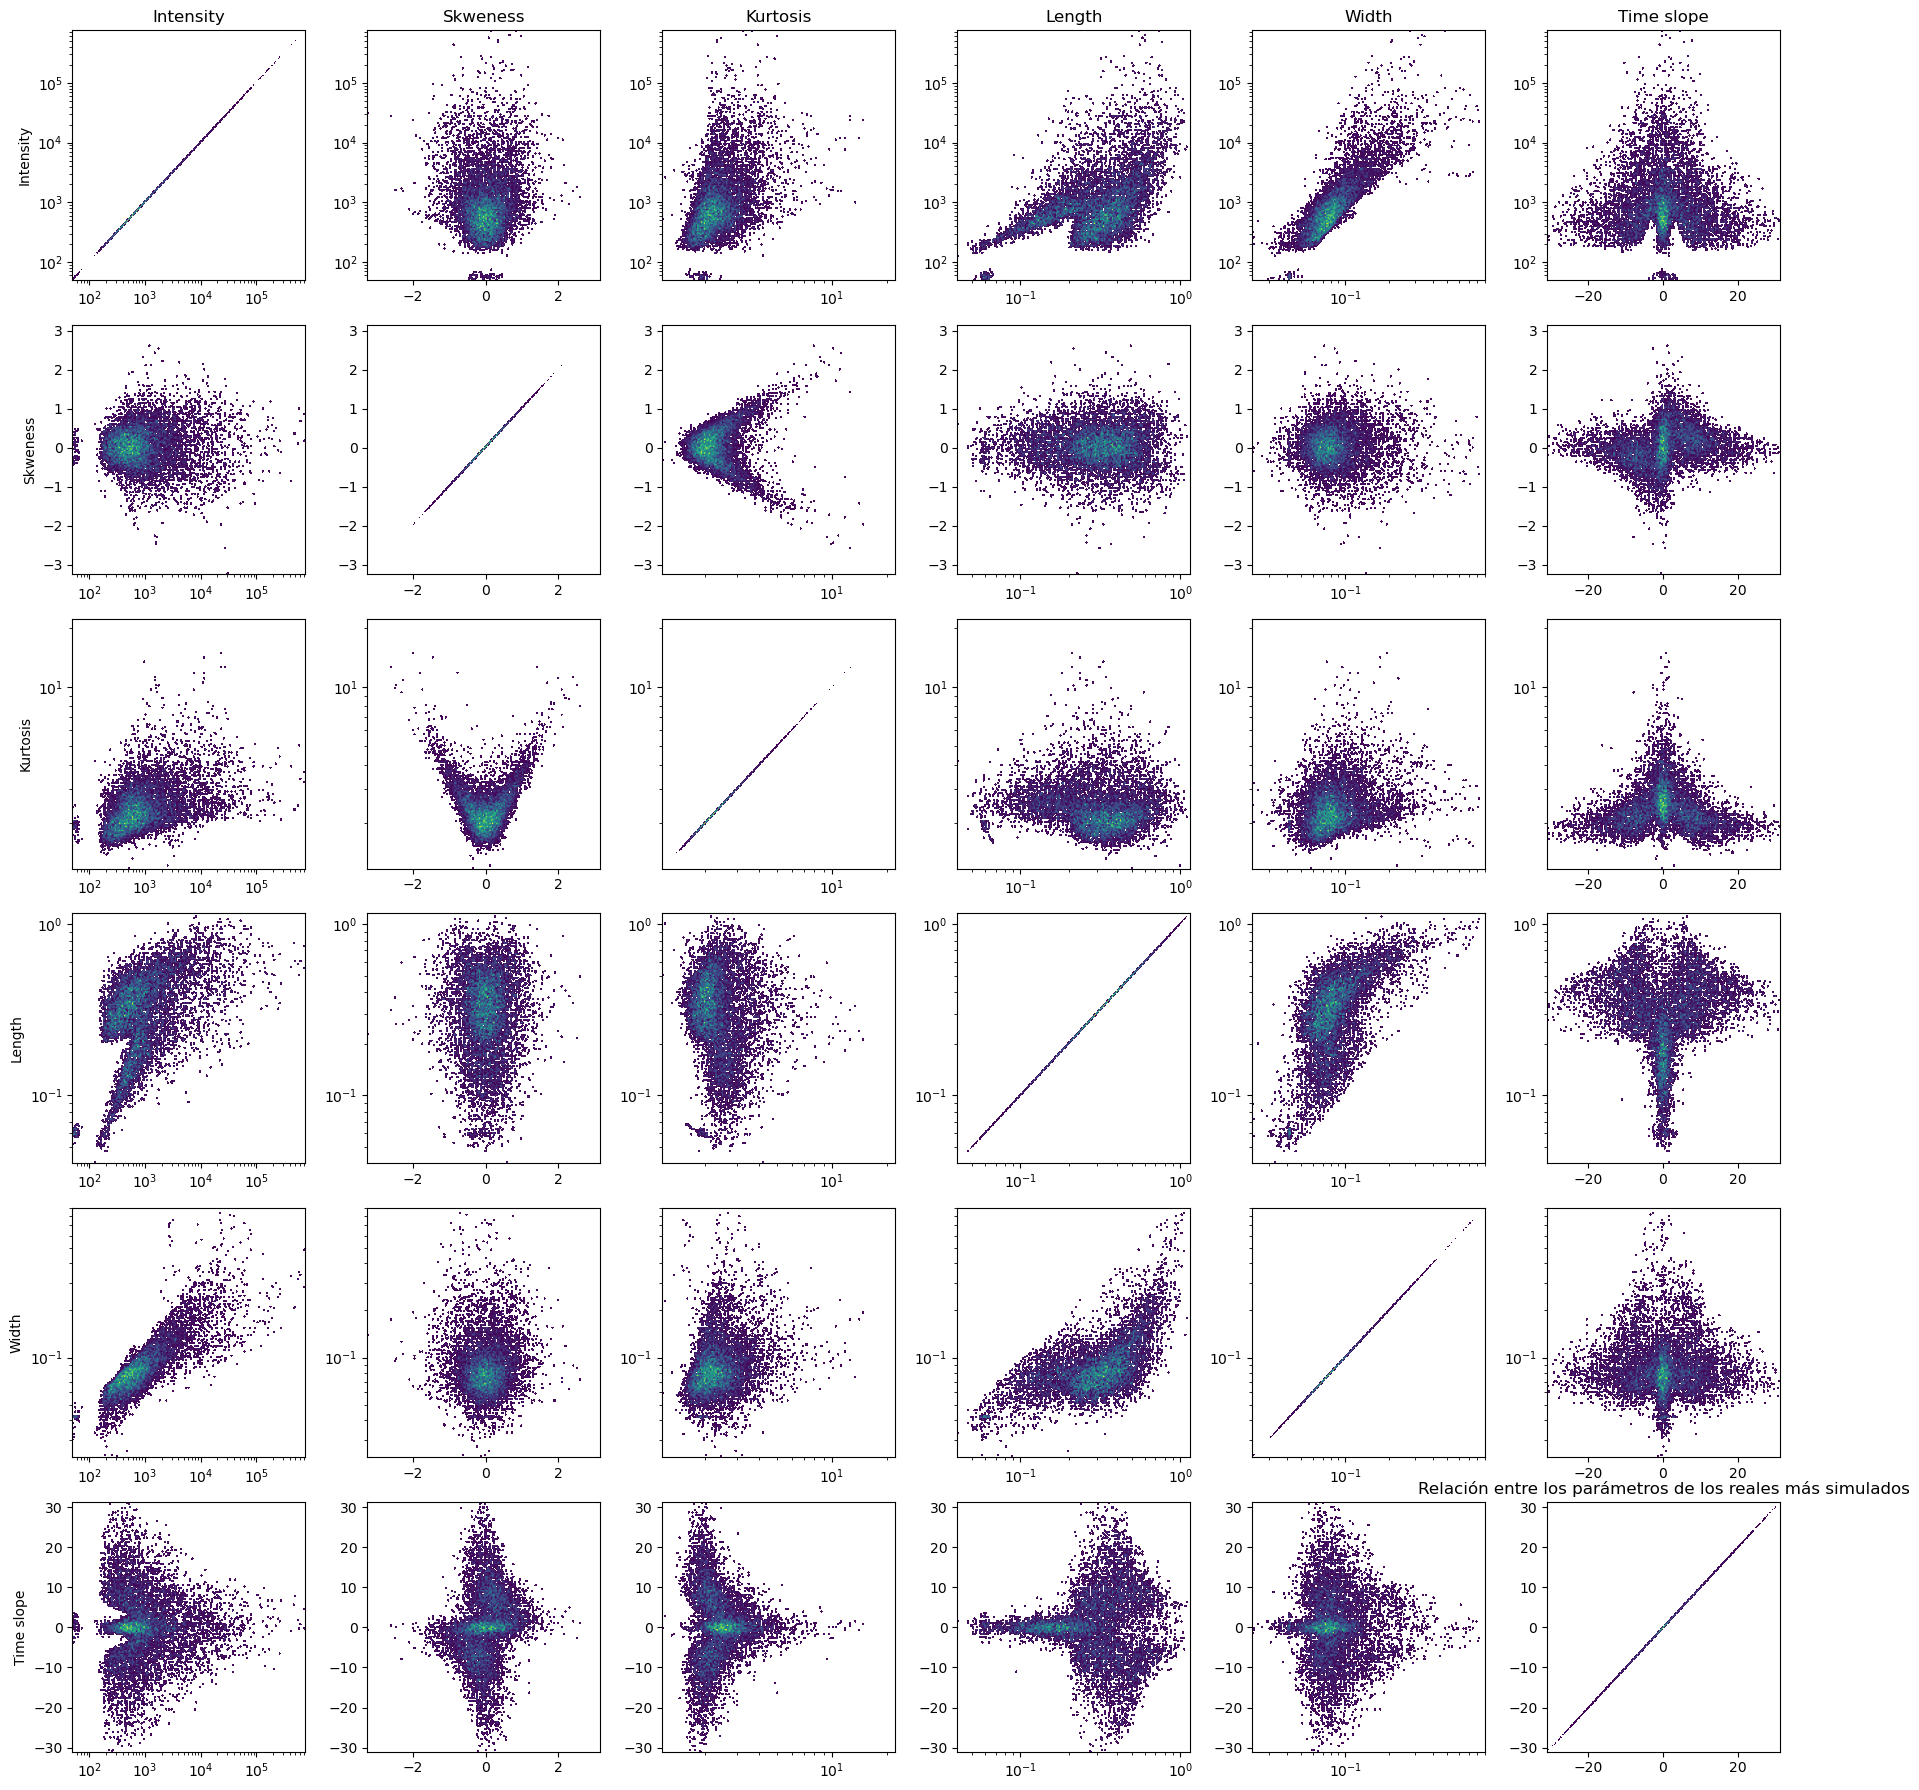

In [11]:
# Crear una cuadrícula de subplots 6x6
fig = plt.figure(figsize=(18, 18))

# Iterar sobre cada subplot y llamar a la función con los datos correspondientes
for i in range(6):
    for j in range(6):
        ax = fig.add_subplot(6, 6, i * 6 + j + 1, projection='scatter_density')
        
        # Establecer títulos de los ejes x e y
        xlabel = titles[j]
        ylabel = titles[i]
        
        # Añadir títulos solo a los subplots del borde
        if i == 0:
            ax.set_title(f"{xlabel}")
        if j == 0:
            ax.set_ylabel(f"{ylabel}")

        # Representar los datos
        using_mpl_scatter_density(ax, X_reales_menos[:, j], X_reales_menos[:, i])
        
plt.tight_layout()
plt.title('Relación entre los parámetros de los reales más simulados')
plt.show()

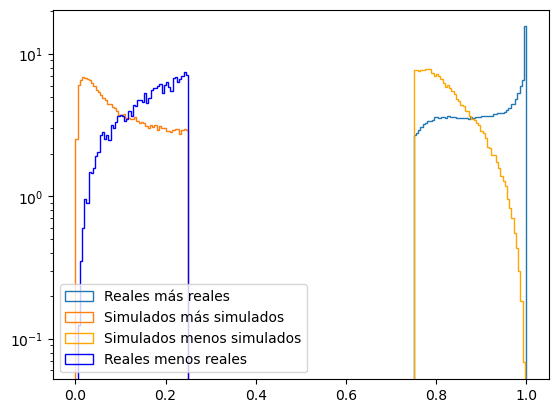

In [12]:
# Representamos en histograma cada grupo para ver si la distribución se asemeja
plt.hist(X_reales_mas[:,7], bins=50, density=True, histtype=u'step', label='Reales más reales')
plt.hist(X_simulados_mas[:,7], bins=50, density=True, histtype=u'step', label='Simulados más simulados')
plt.hist(X_simulados_menos[:,7], bins=50, density=True, histtype=u'step', color = 'orange', label='Simulados menos simulados')
plt.hist(X_reales_menos[:,7], bins=50, density=True, histtype=u'step', color = 'blue', label='Reales menos reales')
plt.yscale('log')
plt.legend()
plt.show()

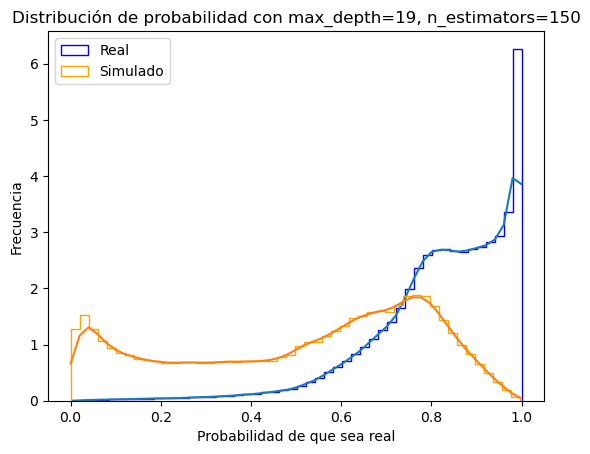

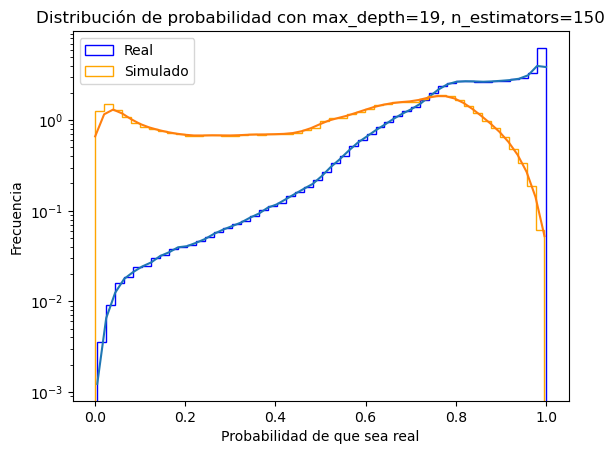

In [13]:
proba = y_pred_total[:,0]                                                                             # Probabilidad de que el suceso sea un gamma
label = y_test_total                                                                                  # Etiqueta real del suceso
    
# Asignamos a cada probabilidad que devuelve el RF la etiqueta real del suceso
prob_real = proba[label == 0]
prob_simu = proba[label == 1]

densityr = stats.gaussian_kde(prob_real)
nr, xr, _ = plt.hist(prob_real, bins=50, density=True, histtype=u'step', color = 'blue', label='Real')  
plt.plot(xr, densityr(xr))

densitys = stats.gaussian_kde(prob_simu)
ns, xs, _ = plt.hist(prob_simu, bins=50, density=True, histtype=u'step', color = 'orange', label='Simulado')  
plt.plot(xs, densitys(xs))

plt.title("Distribución de probabilidad con max_depth=19, n_estimators=150")
plt.xlabel("Probabilidad de que sea real")
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

densityr = stats.gaussian_kde(prob_real)
nr, xr, _ = plt.hist(prob_real, bins=50, density=True, histtype=u'step', color = 'blue', label='Real')  
plt.plot(xr, densityr(xr))

densitys = stats.gaussian_kde(prob_simu)
ns, xs, _ = plt.hist(prob_simu, bins=50, density=True, histtype=u'step', color = 'orange', label='Simulado')  
plt.plot(xs, densitys(xs))

plt.title("Distribución de probabilidad con max_depth=19, n_estimators=150")
plt.xlabel("Probabilidad de que sea real")
plt.ylabel('Frecuencia')
plt.yscale('log')
plt.legend()
plt.show()

TENEMOS CULPABLE!!!!!

SE ACABÓ :)

### 3. Regressor de la energía para ver los espectros

Vamos por último a intentar estudiar los espectros de energía de los diferentes grupos para ver la distribución que siguen

In [2]:
# Cargamos imágenes SIMULADAS
with TableLoader("../datos/proton.dl2.h5", load_dl1_images=True, load_dl2=True,load_simulated=True) as loader_p:
    protons_tel_events = loader_p.read_telescope_events("LST_LST_LSTCam", start=0, stop=1647471)
with TableLoader("../datos/gamma-diffuse.dl2.h5", load_dl1_images=True,load_dl2=True, load_simulated=True) as loader_g:
    gamma_tel_events = loader_g.read_telescope_events("LST_LST_LSTCam", start=0, stop=1452118)

with TableLoader("../datos/proton_with_images_00.dl2.h5", load_dl1_images=True, load_dl2=True,load_simulated=True) as loader_p:
    protons_tel_events2 = loader_p.read_telescope_events("LST_LST_LSTCam", start=0, stop=82178)
with TableLoader("../datos/gamma-diffuse_with_images_00.dl2.h5", load_dl1_images=True,load_dl2=True, load_simulated=True) as loader_g:
    gamma_tel_events2 = loader_g.read_telescope_events("LST_LST_LSTCam", start=0, stop=33922
)

# Determinamos los parámetros
features = [
 #'obs_id',
 #'event_id',                          
 #'tel_id',
 'hillas_intensity',
 'hillas_skewness',
 'hillas_kurtosis',
 #'hillas_r',
 #'hillas_phi',
 'hillas_length',
 'hillas_width',
 #'hillas_psi',
 #'timing_intercept',
 #'timing_deviation',
 'timing_slope',
 #'leakage_intensity_width_2',
 'true_energy'
]

protons_tel_events_f = protons_tel_events[features] 
gamma_tel_events_f=gamma_tel_events[features]
protons_tel_events_f2 = protons_tel_events2[features] 
gamma_tel_events_f2=gamma_tel_events2[features]

# Convertimos a dataframe
df_protons = protons_tel_events_f.to_pandas()
df_protons = df_protons.dropna()

df_protons2 = protons_tel_events_f2.to_pandas()
df_protons2 = df_protons2.dropna()

df_gamma = gamma_tel_events_f.to_pandas()
df_gamma = df_gamma.dropna()

df_gamma2 = gamma_tel_events_f2.to_pandas()
df_gamma2 = df_gamma2.dropna()

# Juntamos los cuatro dataframe
df_protongamma = pd.concat([df_protons, df_protons2, df_gamma, df_gamma2], axis=0)

X = df_protongamma.drop("true_energy", axis=1)
y = df_protongamma["true_energy"]

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
rf = RandomForestRegressor(n_estimators=125)
rf.fit(X, y)

RandomForestRegressor(n_estimators=125)

In [8]:
# Preparamos la representación
import mpl_scatter_density # adds projection='scatter_density'
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches

# "Viridis-like" colormap with white background
white_viridis = LinearSegmentedColormap.from_list('white_viridis', [
    (0, '#ffffff'),
    (1e-20, '#440053'),
    (0.2, '#404388'),
    (0.4, '#2a788e'),
    (0.6, '#21a784'),
    (0.8, '#78d151'),
    (1, '#fde624'),
], N=256)

def using_mpl_scatter_density(fig, x, y):
    ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
    density = ax.scatter_density(x, y, cmap=white_viridis)
    fig.colorbar(density, label='Number of points per pixel')

/gamma5/users/inimar2/anaconda3/envs/lst/lib/python3.11/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/gamma5/users/inimar2/anaconda3/envs/lst/lib/python3.11/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


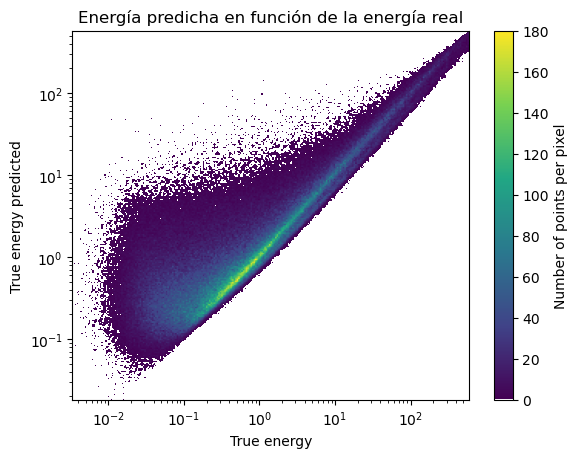

In [9]:
# Comprobamos los resultados con test
y_pred = rf.predict(X_test)
 
fig = plt.figure()
using_mpl_scatter_density(fig, y_test, y_pred)
plt.xlabel('True energy')
plt.ylabel('True energy predicted')
plt.yscale('log')
plt.xscale('log')
plt.title('Energía predicha en función de la energía real')
plt.show()

In [22]:
X_ss = X_simulados_mas[:, :6]
X_sr = X_simulados_menos[:, :6]
X_rr = X_reales_mas[:, :6]
X_rs = X_reales_menos[:, :6]

# Introducimos nuestros grupos para realizar predicciones a su energía
y_pred_ss = rf.predict(X_ss)
y_pred_sr = rf.predict(X_sr)
y_pred_rr = rf.predict(X_rr)
y_pred_rs = rf.predict(X_rs)

/gamma5/users/inimar2/anaconda3/envs/lst/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/gamma5/users/inimar2/anaconda3/envs/lst/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/gamma5/users/inimar2/anaconda3/envs/lst/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/gamma5/users/inimar2/anaconda3/envs/lst/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


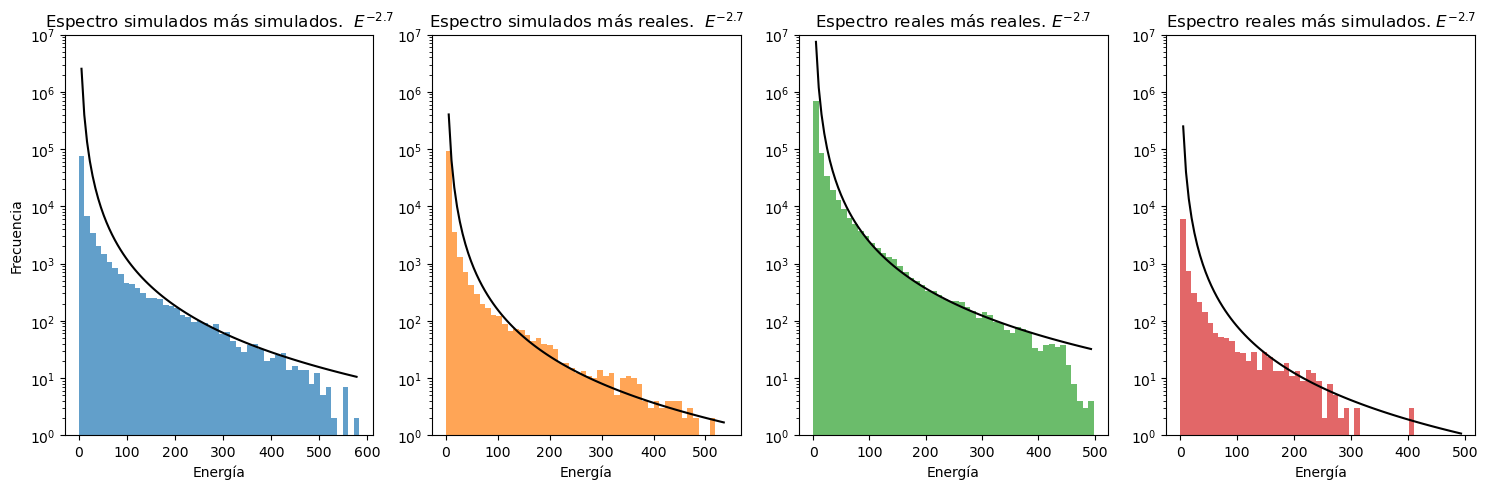

In [59]:
# Calcular el histograma
hist, bin_edges = np.histogram(y_pred_ss, bins=50, density=True)
hist2, bin_edges2 = np.histogram(y_pred_sr, bins=50, density=True)
hist3, bin_edges3 = np.histogram(y_pred_rr, bins=50, density=True)
hist4, bin_edges4 = np.histogram(y_pred_rs, bins=50, density=True)

# Calcular los centros de los bins
x_data = (bin_edges[1:] + bin_edges[:-1]) / 2
x_data2 = (bin_edges2[1:] + bin_edges2[:-1]) / 2
x_data3 = (bin_edges3[1:] + bin_edges3[:-1]) / 2
x_data4 = (bin_edges4[1:] + bin_edges4[:-1]) / 2

# Generar datos para la curva ajustada
x_fit = np.linspace(min(x_data), max(x_data), 100)
y_fit = 300000000*x_fit**(-2.7)
x_fit2 = np.linspace(min(x_data2), max(x_data2), 100)
y_fit2 = 39000000*x_fit2**(-2.7)
x_fit3 = np.linspace(min(x_data3), max(x_data3), 100)
y_fit3 = 600000000*x_fit3**(-2.7)
x_fit4 = np.linspace(min(x_data3), max(x_data3), 100)
y_fit4 = 20000000*x_fit3**(-2.7)

# Representamos sus espectros
fig, axs = plt.subplots(1, 4, figsize=(15, 5))

axs[0].hist(y_pred_ss, 50, alpha = 0.7, color='#1f77b4')
axs[0].plot(x_fit, y_fit, 'k')
axs[0].set_yscale('log')
axs[0].set_ylabel('Frecuencia')
axs[0].set_xlabel('Energía')
axs[0].set_title('Espectro simulados más simulados.  $E^{-2.7}$')
axs[0].set_ylim(1, 10000000)

axs[1].hist(y_pred_sr, 50, alpha = 0.7, color='#ff7f0e')
axs[1].plot(x_fit2, y_fit2, 'k')
axs[1].set_yscale('log')
axs[1].set_xlabel('Energía')
axs[1].set_title('Espectro simulados más reales.  $E^{-2.7}$')
axs[1].set_ylim(1, 10000000)

axs[2].hist(y_pred_rr, 50, alpha = 0.7, color='#2ca02c')
axs[2].plot(x_fit3, y_fit3, 'k')
axs[2].set_yscale('log')
axs[2].set_xlabel('Energía')
axs[2].set_title('Espectro reales más reales. $E^{-2.7}$')
axs[2].set_ylim(1, 10000000)

axs[3].hist(y_pred_rs, 50, alpha = 0.7, color='#d62728')
axs[3].plot(x_fit4, y_fit4, 'k')
axs[3].set_yscale('log')
axs[3].set_xlabel('Energía')
axs[3].set_title('Espectro reales más simulados. $E^{-2.7}$')
axs[3].set_ylim(1, 10000000)

plt.tight_layout()
plt.show()

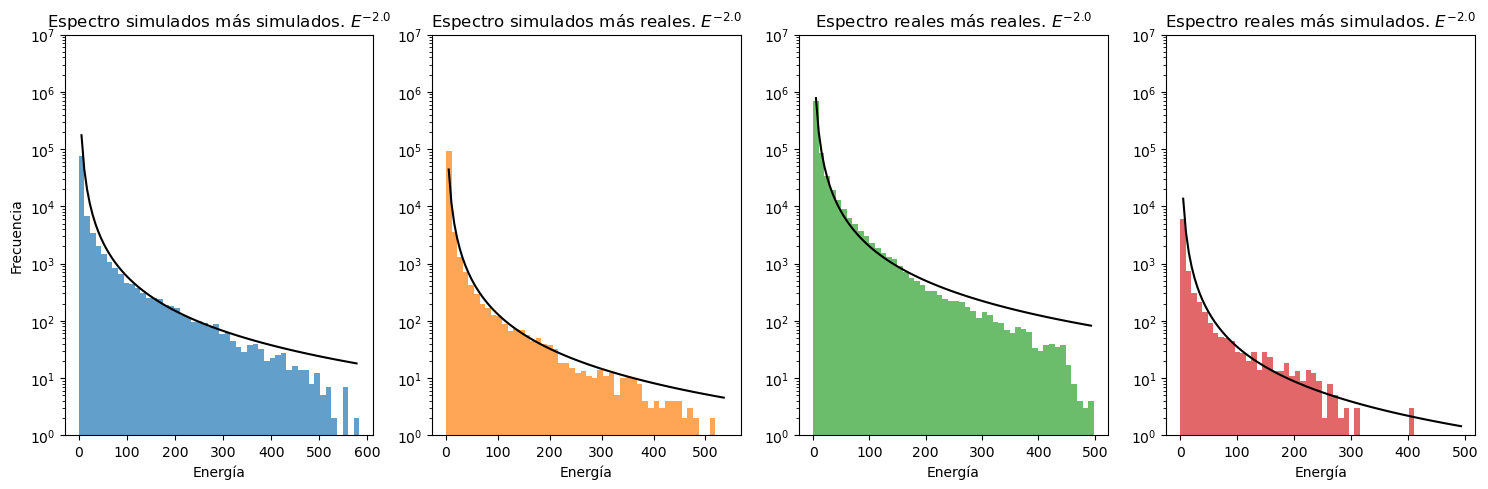

In [60]:
# Calcular el histograma
hist, bin_edges = np.histogram(y_pred_ss, bins=50, density=True)
hist2, bin_edges2 = np.histogram(y_pred_sr, bins=50, density=True)
hist3, bin_edges3 = np.histogram(y_pred_rr, bins=50, density=True)
hist4, bin_edges4 = np.histogram(y_pred_rs, bins=50, density=True)

# Calcular los centros de los bins
x_data = (bin_edges[1:] + bin_edges[:-1]) / 2
x_data2 = (bin_edges2[1:] + bin_edges2[:-1]) / 2
x_data3 = (bin_edges3[1:] + bin_edges3[:-1]) / 2
x_data4 = (bin_edges4[1:] + bin_edges4[:-1]) / 2

# Generar datos para la curva ajustada
x_fit = np.linspace(min(x_data), max(x_data), 100)
y_fit = 6000000*x_fit**(-2.0)
x_fit2 = np.linspace(min(x_data2), max(x_data2), 100)
y_fit2 = 1300000*x_fit2**(-2.0)
x_fit3 = np.linspace(min(x_data3), max(x_data3), 100)
y_fit3 = 20000000*x_fit3**(-2.0)
x_fit4 = np.linspace(min(x_data3), max(x_data3), 100)
y_fit4 = 350000*x_fit3**(-2.0)

# Representamos sus espectros
fig, axs = plt.subplots(1, 4, figsize=(15, 5))

axs[0].hist(y_pred_ss, 50, alpha = 0.7, color='#1f77b4')
axs[0].plot(x_fit, y_fit, 'k')
axs[0].set_yscale('log')
axs[0].set_ylabel('Frecuencia')
axs[0].set_xlabel('Energía')
axs[0].set_title('Espectro simulados más simulados. $E^{-2.0}$')
axs[0].set_ylim(1, 10000000)

axs[1].hist(y_pred_sr, 50, alpha = 0.7, color='#ff7f0e')
axs[1].plot(x_fit2, y_fit2, 'k')
axs[1].set_yscale('log')
axs[1].set_xlabel('Energía')
axs[1].set_title('Espectro simulados más reales. $E^{-2.0}$')
axs[1].set_ylim(1, 10000000)

axs[2].hist(y_pred_rr, 50, alpha = 0.7, color='#2ca02c')
axs[2].plot(x_fit3, y_fit3, 'k')
axs[2].set_yscale('log')
axs[2].set_xlabel('Energía')
axs[2].set_title('Espectro reales más reales. $E^{-2.0}$')
axs[2].set_ylim(1, 10000000)

axs[3].hist(y_pred_rs, 50, alpha = 0.7, color='#d62728')
axs[3].plot(x_fit4, y_fit4, 'k')
axs[3].set_yscale('log')
axs[3].set_xlabel('Energía')
axs[3].set_title('Espectro reales más simulados. $E^{-2.0}$')
axs[3].set_ylim(1, 10000000)

plt.tight_layout()
plt.show()